# 2. Exploring Landsat-8 image time series on AWS

https://aws.amazon.com/public-datasets/landsat/ 

This notebook demonstrates how to search for multiple landsat8 scenes on AWS, load *subsets* of scenes into your local computer memory, and do some simple time series analysis. This funcionality is a work in progress, with very exciting developments in the xarray and dask python libraries

Landsat-8 is an Earth-imaging satellite administered by the United States Geological Survey (USGS). The Landsat 8 satellite carries two instruments: the Operational Land Imager (OLI) and the Thermal Infrared Sensor (TIRS). Data is provided as 11 grayscale bands at a depth of 16 bits, along with a quality assessment band, also at 16 bits. However, sensor resolution is only at 12 bits, or 4096 gray levels.
https://landsat.usgs.gov/landsat-8

In [1]:
import os
import glob

import satsearch.main as main

import geopandas as gpd
import pandas as pd

import xarray

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set environment variables for cloud-optimized-geotiff efficiency
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='YES'
os.environ['CURL_CA_BUNDLE']='/etc/ssl/certs/ca-certificates.crt'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS']='TIF' 

# Search for scenes over a timespan:


In [3]:
# Scenes from particular row, col are on same UTM grid
# Programmatic:
search_params = dict(date_from='2017-04-30',
                     date_to = '2018-04-30',
                     satellite_name = 'landsat-8',
                     row=27,
                     path=47,
                     contains='-122.335167,47.608013',
                     )
scenes = main.main(**search_params)
scenes.print_scenes()
scenes.save('last-year.json')

23 scenes found
Scenes (23):
        date              scene_id      
     2017-05-02     LC80470272017122LGN00
     2017-05-18     LC80470272017138LGN00
     2017-06-03     LC80470272017154LGN00
     2017-06-19     LC80470272017170LGN00
     2017-07-05     LC80470272017186LGN00
     2017-07-21     LC80470272017202LGN00
     2017-08-06     LC80470272017218LGN00
     2017-08-22     LC80470272017234LGN00
     2017-09-07     LC80470272017250LGN00
     2017-09-23     LC80470272017266LGN00
     2017-10-09     LC80470272017282LGN00
     2017-10-25     LC80470272017298LGN00
     2017-11-10     LC80470272017314LGN00
     2017-11-26     LC80470272017330LGN00
     2017-12-12     LC80470272017346LGN00
     2017-12-28     LC80470272017362LGN00
     2018-01-13     LC80470272018013LGN00
     2018-01-29     LC80470272018029LGN00
     2018-02-14     LC80470272018045LGN00
     2018-03-02     LC80470272018061LGN00
     2018-03-18     LC80470272018077LGN00
     2018-04-03     LC80470272018093LGN01
     2

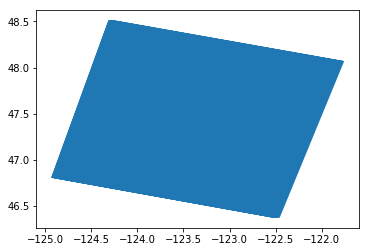

In [4]:
gf = gpd.read_file('last-year.json')
#print(gf.info())
gf.plot()

# Create local VRT files that point to Cloud storage

In [5]:
def make_vrts(gf, outdir, bands=[4,5], extent='-122.46 47.45 -122.07 47.73'):
    '''  Write local VRTs (http://www.gdal.org/gdal_vrttut.html) that point to all bands on S3'''
    os.chdir(outdir) #this will create a bunch of files, so keep them in another directory
    
    for i,row in gf.iterrows():
        s3index = row.aws_index
        url = s3index.rstrip('/index.html').replace('https://', '/vsicurl/')
        id = s3index.split('/')[-2]
        print(url)
        for band in bands:
            cmd = f'gdal_translate -of VRT {url}/{id}_B{band}.TIF {id}_B{band}.vrt'
            #print(cmd)
            os.system(cmd)
        cmd = f'gdalbuildvrt -separate {id}.vrt {id}_B*.vrt'
        print(cmd)
        os.system(cmd)

        cmd = f'gdalwarp -r bilinear -of VRT -t_srs EPSG:4326 -te {extent} {id}.vrt {id}-wgs84.vrt'
        print(cmd)
        os.system(cmd)
    
    os.chdir('../')
    
    return f'{id}.vrt'

In [6]:
outdir = 'tmpdir'
# Uncomment to regenerate VRTs
#os.mkdir(outdir)
#make_vrts(gf, outdir)

In [7]:
# Probably a better way of getting time-stamped data into xarray, but this works
# Xarray works best with netCDF files currently, but those don't yet have COG-like access on S3
datasets = []
vrtPaths = glob.glob(f'{outdir}/*T1-wgs84.vrt')
df = pd.DataFrame(dict(vrt=vrtPaths))
df['datestr'] = df.vrt.apply(lambda x: x.split('_')[4])
df['datetime'] = pd.to_datetime(df.datestr)
df = df.sort_values('datetime').reset_index(drop=True)
df.head()

,vrt,datestr,datetime
0,tmpdir/LC08_L1TP_047027_20170502_20170515_01_T...,20170515,2017-05-15
1,tmpdir/LC08_L1TP_047027_20170518_20170525_01_T...,20170525,2017-05-25
2,tmpdir/LC08_L1TP_047027_20170603_20170615_01_T...,20170615,2017-06-15
3,tmpdir/LC08_L1TP_047027_20170619_20170630_01_T...,20170630,2017-06-30
4,tmpdir/LC08_L1TP_047027_20170705_20170716_01_T...,20170716,2017-07-16


In [8]:
# NOTE: don't need coordinates as float64 probably...
datasets = []
for i,row in df.iterrows():
    da = xarray.open_rasterio(row.vrt)
    ds = da.to_dataset(dim='band').rename({1:'Band4', 2:'Band5'})
    datasets.append(ds)

In [9]:
# Concatenate
# Reading everything into memory?
DS = xarray.concat(datasets, dim=pd.DatetimeIndex(df.datetime.values, name='time'))

In [10]:
DS

<xarray.Dataset>
Dimensions:  (time: 16, x: 2295, y: 824)
Coordinates:
  * x        (x) float64 -122.5 -122.5 -122.5 -122.5 -122.5 -122.5 -122.5 ...
  * y        (y) float64 47.73 47.73 47.73 47.73 47.73 47.73 47.73 47.73 ...
  * time     (time) datetime64[ns] 2017-05-15 2017-05-25 2017-06-15 ...
Data variables:
    Band4    (time, y, x) float64 1.072e+04 nan 1.057e+04 nan 1.035e+04 nan ...
    Band5    (time, y, x) float64 1.089e+04 nan 1.07e+04 nan 1.042e+04 nan ...
Attributes:
    transform:   (0.0003397212543554012, 0.0, -122.46, 0.0, -0.00033980582524...
    crs:         +init=epsg:4326
    res:         (0.0003397212543554012, 0.0003398058252427112)
    is_tiled:    1
    nodatavals:  (nan, nan)

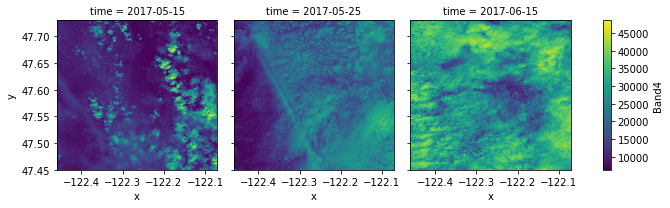

In [11]:
# Now you can do pretty magical things with xarray indexing
# Mean NVDI, NDVI between certain dates, NDVI timeseries at a location, etc!...
# Plus nice plotting features
grid = DS['Band4'][:3].plot(x='x', y='y', col='time', col_wrap=3, center=False)

In [12]:
NDVI = (DS['Band5'] - DS['Band4']) / (DS['Band5'] + DS['Band4'])

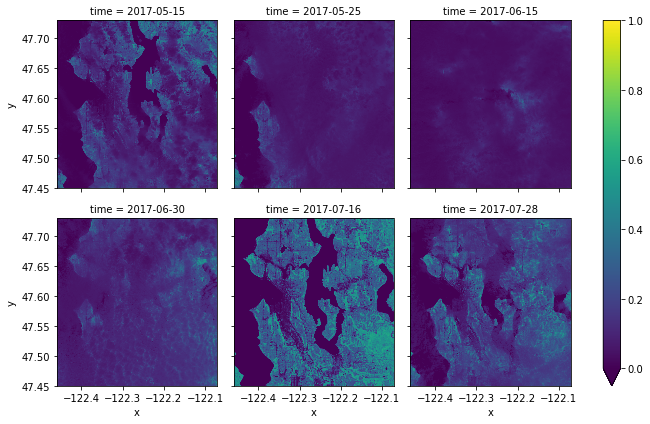

In [13]:
# Equivalent
#NDVI[:6].plot(x='x', y='y', col='time', col_wrap=3, center=False, vmin=0, vmax=1)
NDVI.sel(time=slice('2017-05-01', '2017-08-01')).plot(x='x', y='y', col='time', col_wrap=3, center=False, vmin=0, vmax=1)

## Conclusions

* We analyzed 16 landsat 8 scenes and only took up ~1 Mb of disk space!!!
* The traditional "download and process" workflow would require downloading ~16 Gb of full resolution multiband imagery (https://search.earthdata.nasa.gov)
* Exciting improvements are on the horizon to work with data on the cloud in parallel (Xarray+Dask on the cloud - https://mrocklin.github.com/blog/work/2018/01/22/pangeo-2)